In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rossmann-store-sales:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F109852%2F262482%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241004%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241004T180906Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D12eaeb304e836b2589ec28858af564708aa71872a26a913a8b597a382ac9ec5783705e8100af7fedac490221e7c7f495c903ba527dda18c155ff52090641fed988ac849cd6bb52f8a90cafb14d742f66979fcaca5d5944f398bc2bb52c085917d3aff53794229944dc12221139f5a834585c5042a6c8fa159054d0febcf8fb3f172e85369530ba6215588752543c056a41eb30952b70ea8498d24cd2a01ec45a9f8a0415fa0d37e2979177adc8c5826df6fcb25c0f7a64bbc095606ed82f6c5763991bf0d0da07bca6e5d1c8b2a872762eecf8eaecd7463cb002f29bbb9b54b9948bbfaeb8e4055d97ad570c90e28af7f2dec9577deb2bf46754ea629ee5c462'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7240167 bytes downloaded
Downloaded and uncompressed: rossmann-store-sales
Data source import complete.


In [ ]:
## sklearn -- Preprocessing & Tuning & Transformation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
## sklearn -- metrics
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
# Step 1: Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score ,mean_absolute_error

import joblib
# Sample Data Preparation
# Replace this with your actual data
## sklearn -- Models
## Xgboost
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)


In [ ]:
Ross_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False)
Store_df = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
Test_df = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')

# Ross_df = pd.read_csv(r'D:\leetcode\archive\train.csv', low_memory=False)
# Store_df = pd.read_csv(r'D:\leetcode\archive\store.csv')
# Test_df = pd.read_csv(r'D:\leetcode\archive\test.csv')

In [ ]:
# Load your dataset
data = Ross_df.merge(Store_df, how='left', on='Store')
data.to_csv('data.csv', index=False)
data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extract features from 'Date' column
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekOfYear'] = data['Date'].dt.isocalendar().week.astype(int)
data['DayOfWeek'] = data['Date'].dt.dayofweek
data =data.drop(columns=['Date', ], axis=1)


#  Feature Engineer

In [ ]:

## Try to make some Feature Engineering --> Feature Extraction --> Add the new column to the main DF
data["SalesPerCustomer"]=np.where(data['Customers'] == 0, 0, data['Store'] / data['Customers'])

data['SalesPerDistance'] = np.where(data['CompetitionDistance'] == 0, 0, data['Store'] / data['CompetitionDistance'])

# %%
# # Handling missing values for both features
# data['CompetitionOpenSinceYear'].fillna(0, inplace=True)
# data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
# data['Promo2SinceYear'].fillna(0, inplace=True)
# data['Promo2SinceWeek'].fillna(0, inplace=True)

# Merge CompetitionOpenSinceYear and CompetitionOpenSinceMonth into 'CompetitionOpenSince'
data['CompetitionOpenSince'] = data['CompetitionOpenSinceYear']* data['CompetitionOpenSinceMonth']

# Merge Promo2SinceYear and Promo2SinceWeek into 'Promo2Since'
data['Promo2Since'] = data['Promo2SinceYear']  * data['Promo2SinceWeek']

data = data.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1)
data =data.drop(columns=['Promo2SinceYear', 'Promo2SinceWeek',"Promo2SinceWeek"], axis=1)


In [ ]:
data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer,SalesPerDistance,CompetitionOpenSince,Promo2Since
0,1,4,5263,555,1,1,0,1,c,a,...,0,NaN,2015,7,31,31,0.001802,0.000787,18072.0,NaN
1,2,4,6064,625,1,1,0,1,a,a,...,1,"Jan,Apr,Jul,Oct",2015,7,31,31,0.003200,0.003509,22077.0,26130.0
2,3,4,8314,821,1,1,0,1,a,a,...,1,"Jan,Apr,Jul,Oct",2015,7,31,31,0.003654,0.000212,24072.0,28154.0
3,4,4,13995,1498,1,1,0,1,c,c,...,0,NaN,2015,7,31,31,0.002670,0.006452,18081.0,NaN
4,5,4,4822,559,1,1,0,1,a,a,...,0,NaN,2015,7,31,31,0.008945,0.000167,8060.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,0,0,0,0,a,1,a,a,...,1,"Jan,Apr,Jul,Oct",2013,1,1,1,0.000000,0.584737,12084.0,62403.0
1017205,1112,1,0,0,0,0,a,1,c,c,...,0,NaN,2013,1,1,1,0.000000,0.591489,8024.0,NaN
1017206,1113,1,0,0,0,0,a,1,a,c,...,0,NaN,2013,1,1,1,0.000000,0.120194,NaN,NaN
1017207,1114,1,0,0,0,0,a,1,a,c,...,0,NaN,2013,1,1,1,0.000000,1.280460,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Store                 1017209 non-null  int64  
 1   DayOfWeek             1017209 non-null  int32  
 2   Sales                 1017209 non-null  int64  
 3   Customers             1017209 non-null  int64  
 4   Open                  1017209 non-null  int64  
 5   Promo                 1017209 non-null  int64  
 6   StateHoliday          1017209 non-null  object 
 7   SchoolHoliday         1017209 non-null  int64  
 8   StoreType             1017209 non-null  object 
 9   Assortment            1017209 non-null  object 
 10  CompetitionDistance   1014567 non-null  float64
 11  Promo2                1017209 non-null  int64  
 12  PromoInterval         509178 non-null   object 
 13  Year                  1017209 non-null  int32  
 14  Month                 1017209 non-

In [ ]:
data.columns


Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'PromoInterval', 'Year', 'Month',
       'Day', 'WeekOfYear', 'SalesPerCustomer', 'SalesPerDistance',
       'CompetitionOpenSince', 'Promo2Since'],
      dtype='object')

In [ ]:
data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer,SalesPerDistance,CompetitionOpenSince,Promo2Since
0,1,4,5263,555,1,1,0,1,c,a,...,0,NaN,2015,7,31,31,0.001802,0.000787,18072.0,NaN
1,2,4,6064,625,1,1,0,1,a,a,...,1,"Jan,Apr,Jul,Oct",2015,7,31,31,0.003200,0.003509,22077.0,26130.0
2,3,4,8314,821,1,1,0,1,a,a,...,1,"Jan,Apr,Jul,Oct",2015,7,31,31,0.003654,0.000212,24072.0,28154.0
3,4,4,13995,1498,1,1,0,1,c,c,...,0,NaN,2015,7,31,31,0.002670,0.006452,18081.0,NaN
4,5,4,4822,559,1,1,0,1,a,a,...,0,NaN,2015,7,31,31,0.008945,0.000167,8060.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,0,0,0,0,a,1,a,a,...,1,"Jan,Apr,Jul,Oct",2013,1,1,1,0.000000,0.584737,12084.0,62403.0
1017205,1112,1,0,0,0,0,a,1,c,c,...,0,NaN,2013,1,1,1,0.000000,0.591489,8024.0,NaN
1017206,1113,1,0,0,0,0,a,1,a,c,...,0,NaN,2013,1,1,1,0.000000,0.120194,NaN,NaN
1017207,1114,1,0,0,0,0,a,1,a,c,...,0,NaN,2013,1,1,1,0.000000,1.280460,NaN,NaN


# Split Data

In [ ]:
# %%
# Take a sample of 10,000 records for training and testing
data_sample = data.sample(n=100000, random_state=42)
# Split the whole dataset into features (X) and target (y)
X = data_sample.drop(columns=['Sales'], axis=1)   # Features (dropping 'Sales', 'Date')
y = data_sample['Sales']   # Target (Sales)

In [ ]:
## Random split the dataset to two sets (train_set, test_set)
## For validation ---  I will use Cross Validation
# Take a sample of 10,000 records for training and testing
data_sample = data.sample(n=100000, random_state=42)
# Split the whole dataset into features (X) and target (y)
X = data_sample.drop(columns=['Sales'], axis=1)   # Features (dropping 'Sales', 'Date')
y = data_sample['Sales']   # Target (Sales)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)
X_train, X_vald, y_train, y_vald = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, random_state=42)
X_train.to_csv('X_train.csv', index=False)

## Check Shapes of these Sets
print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_train shape -- ', X_vald.shape)
print('y_train shape -- ', y_vald.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)


X_train shape --  (72250, 20)
y_train shape --  (72250,)
X_train shape --  (12750, 20)
y_train shape --  (12750,)
X_test shape --  (15000, 20)
y_test shape --  (15000,)


In [ ]:
X_train.isna().sum()

,0
Store,0
DayOfWeek,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0
Assortment,0
CompetitionDistance,186


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72250 entries, 819189 to 965533
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Store                 72250 non-null  int64  
 1   DayOfWeek             72250 non-null  int32  
 2   Customers             72250 non-null  int64  
 3   Open                  72250 non-null  int64  
 4   Promo                 72250 non-null  int64  
 5   StateHoliday          72250 non-null  object 
 6   SchoolHoliday         72250 non-null  int64  
 7   StoreType             72250 non-null  object 
 8   Assortment            72250 non-null  object 
 9   CompetitionDistance   72064 non-null  float64
 10  Promo2                72250 non-null  int64  
 11  PromoInterval         35987 non-null  object 
 12  Year                  72250 non-null  int32  
 13  Month                 72250 non-null  int32  
 14  Day                   72250 non-null  int32  
 15  WeekOfYear        

# Pipline of Data for Deal nulls and scal data

In [ ]:
## Separete the columns according to type (numerical or categorical)
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['float32', 'float64', 'int32', 'int64']]


print('Numerical Columns : \n', num_cols)


Numerical Columns : 
 ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day', 'WeekOfYear', 'SalesPerCustomer', 'SalesPerDistance', 'CompetitionOpenSince', 'Promo2Since']


In [ ]:
# Define categorical and numerical columns

num_cols_meadin =[ 'CompetitionDistance', 'SalesPerCustomer', 'SalesPerDistance', 'CompetitionOpenSince', 'Promo2Since']
num_cols_mostfrq=['Store','DayOfWeek','Customers', 'Open', 'Promo', 'SchoolHoliday','Promo2', 'Year', 'Month', 'Day', 'WeekOfYear']


In [ ]:
categ_cols = [col for col in X_train.columns if X_train[col].dtype not in ['float32', 'float64', 'int32', 'int64']]
print('Categorical Columns : \n', categ_cols)
categ_cols_lable=['StateHoliday', 'StoreType','PromoInterval']
categ_cols_onehot=[ 'Assortment']

Categorical Columns : 
 ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']


In [ ]:
# Define the pipeline for categorical columns with One-Hot Encoding
categ_pipeline_Onehot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder( drop='first', handle_unknown='ignore'))  # One-hot encode categorical variables
])

# Custom transformer for Label Encoding
def label_encode(X):
    le = LabelEncoder()
    return np.array([le.fit_transform(col) for col in X.T]).T

categ_pipeline_Label = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('label_encode', FunctionTransformer(label_encode, validate=False))  # Label encode categorical variables
])


In [ ]:
# Define the pipeline for numerical columns
num_pipeline_median = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize the numerical features
])

# Pipeline for numerical columns with most frequent imputation
num_pipeline_most_frequent = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
])

In [ ]:
# Build the full pipeline with ColumnTransformer
full_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline_median', num_pipeline_median, num_cols_meadin),  # Numerical pipeline
    ('num_pipeline_most_frequent', num_pipeline_most_frequent, num_cols_mostfrq),  # Categorical pipeline
    ('categ_pipeline_Onehot', categ_pipeline_Onehot, categ_cols_onehot),
    ('categ_pipeline_Label', categ_pipeline_Label, categ_cols_lable) # Pipeline for 'Assortment'

])
joblib.dump(full_pipeline, 'full_pipeline.pkl')

['full_pipeline.pkl']

In [ ]:
# Apply the full pipeline to the training and test sets
X_train_prepared = full_pipeline.fit_transform(X_train)
X_vald_prepared=full_pipeline.transform(X_vald)
X_test_prepared = full_pipeline.transform(X_test)

# Check the resulting shape after transformation
print('X_train_prepared shape:', X_train_prepared.shape)
print('X_vald_prepared shape:', X_vald_prepared.shape)
print('X_test_prepared shape:', X_test_prepared.shape)

X_train_prepared shape: (72250, 21)
X_vald_prepared shape: (12750, 21)
X_test_prepared shape: (15000, 21)


# Model and evaluation

In [ ]:
# Assuming X_train_prepared, X_vald_prepared, y_train, and y_vald are already defined
# Define the models with their respective hyperparameters
models = {
    'SGDRegressor': {
        'model': SGDRegressor(),
        'params': {
            'loss': ['squared_error', 'huber'],
            'alpha': [0.001, 0.01],
            'penalty': ['elasticnet', 'l2'],
            'learning_rate': ['adaptive', 'constant', 'invscaling'],
            'max_iter': [1000, 2000],
            'tol': [1e-4]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree']
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(),
        'params': {
            'learning_rate': [0.1, 0.01],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0],
            'gamma': [0, 0.1]
        }
    }
}

# Initialize results and feature importance dictionary
results = []
feature_importances_dict = {}

# Progress tracker variables
total_models = len(models)
current_model = 1

# Loop to perform Grid Search on each model and evaluate
for name, config in models.items():
    print(f"\nStarting Grid Search for model: {name} ({current_model}/{total_models})")
    grid = GridSearchCV(config['model'], config['params'], scoring='neg_mean_squared_error', cv=3, verbose=2)
    grid.fit(X_train_prepared, y_train)

    # Log best parameters found
    print(f"Best parameters for {name}: {grid.best_params_}")

    # Get best estimator and predict
    best_model = grid.best_estimator_
    y_vald_pred = best_model.predict(X_vald_prepared)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_vald, y_vald_pred)
    mse = mean_squared_error(y_vald, y_vald_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_vald, y_vald_pred)

    # Append the results
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

    # Save the best model
    model_filename = f"{name}_best_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Model {name} saved as {model_filename}")

    # Print evaluation metrics after each model finishes
    print(f"Evaluation for {name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f} \n'Best Params': {grid.best_params_}")

    # Update progress tracker
    current_model += 1

# Convert results to DataFrame for summary
df_results = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(df_results)




Starting Grid Search for model: SGDRegressor (1/3)
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END alpha=0.001, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   3.6s
[CV] END alpha=0.001, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   2.0s
[CV] END alpha=0.001, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   2.7s
[CV] END alpha=0.001, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2, tol=0.0001; total time=   2.0s
[CV] END alpha=0.001, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2, tol=0.0001; total time=   2.4s
[CV] END alpha=0.001, learning_rate=adaptive, loss=squared_error, max_iter=1000, penalty=l2, tol=0.0001; total time=   1.7s
[CV] END alpha=0.001, learning_rate=adaptive, loss=squared_error, max_iter=2000, penalty=elasticnet, tol=0.0001; total

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for SGDRegressor: {'alpha': 0.001, 'learning_rate': 'invscaling', 'loss': 'huber', 'max_iter': 2000, 'penalty': 'elasticnet', 'tol': 0.0001}
Model SGDRegressor saved as SGDRegressor_best_model.pkl
Evaluation for SGDRegressor - MAE: 1076.9058, MSE: 3076065.5728, RMSE: 1753.8716, R²: 0.7878 
'Best Params': {'alpha': 0.001, 'learning_rate': 'invscaling', 'loss': 'huber', 'max_iter': 2000, 'penalty': 'elasticnet', 'tol': 0.0001}

Starting Grid Search for model: KNeighborsRegressor (2/3)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   7.0s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   5.9s
[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   6.2s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   7.0s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   5.6s
[CV] END ....algorithm=auto, n

In [ ]:
from pathlib import Path


# New Section

In [ ]:
# Initialize variables
results = []  # To store results of each model evaluation
current_model = 0  # Progress tracker

# Ensure X_test_prepared and y_test are already defined
# X_test_prepared = ...
# y_test = ...

# Loop through all model files with ".pkl" extension
for model_path in Path("/content/").rglob("*.pkl"):
    try:
        # Load the model
        model = joblib.load(model_path)

        # Assuming the loaded model has a predict method (could be GridSearchCV or a normal model)
        X_test_pred = model.predict(X_test_prepared)  # Ensure X_test_prepared is defined

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, X_test_pred)
        mse = mean_squared_error(y_test, X_test_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, X_test_pred)

        # Append the results for this model
        result = {
            'Model': model_path.stem,  # Get the model name from the file path
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        }

        # If model is GridSearchCV or similar, it should have best_params_ attribute
        if hasattr(model, 'best_params_'):
            result['Best Params'] = model.best_params_

        results.append(result)

        # Print evaluation metrics after each model finishes
        print(f"Evaluation for {model_path.stem} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
        if 'Best Params' in result:
            print(f"Best Params: {result['Best Params']}")

    except Exception as e:
        print(f"Error processing {model_path.stem}: {e}")

    # Update progress tracker
    current_model += 1
    print(f"Processed {current_model} models")

# Convert results to DataFrame for summary
df_results = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(df_results)

# Optionally, save results to a CSV
# df_results.to_csv("model_evaluation_results.csv", index=False)

Evaluation for KNeighborsRegressor_best_model - MAE: 948.7577, MSE: 2091309.6346, RMSE: 1446.1361, R²: 0.8600
Processed 1 models
Evaluation for XGBRegressor_best_model - MAE: 353.1305, MSE: 300593.8642, RMSE: 548.2644, R²: 0.9799
Processed 2 models
Error processing full_pipeline: 'ColumnTransformer' object has no attribute 'predict'
Processed 3 models
Evaluation for SGDRegressor_best_model - MAE: 1096.4095, MSE: 3234880.7779, RMSE: 1798.5774, R²: 0.7834
Processed 4 models

Final Results Summary:
                            Model          MAE           MSE         RMSE  \
0  KNeighborsRegressor_best_model   948.757744  2.091310e+06  1446.136105   
1         XGBRegressor_best_model   353.130498  3.005939e+05   548.264411   
2         SGDRegressor_best_model  1096.409454  3.234881e+06  1798.577432   

         R²  
0  0.859963  
1  0.979872  
2  0.783388  


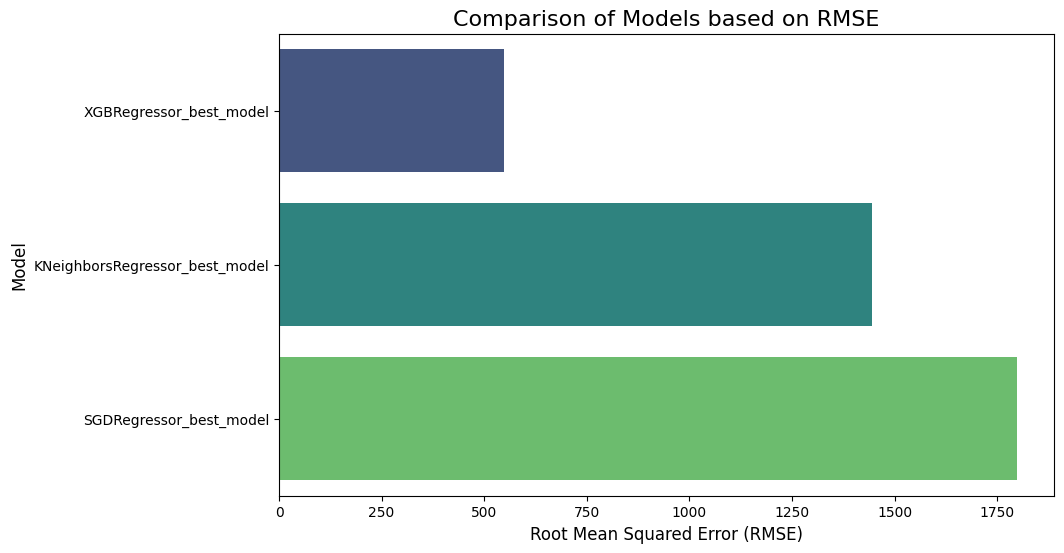

In [ ]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Sort the DataFrame by RMSE to make the plot more interpretable
df_results_sorted = df_results.sort_values(by='RMSE')

# Create a bar plot for RMSE of each model
sns.barplot(x='RMSE', y='Model', data=df_results_sorted, palette='viridis')

# Add titles and labels
plt.title('Comparison of Models based on RMSE', fontsize=16)
plt.xlabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Show the plot
plt.show()

In [ ]:
d=pd.DataFrame(X_train_prepared)
